In [1]:
import json
import pandas as pd
import numpy as np
import csv
import os

import geopandas #as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

from shapely.geometry import Point, Polygon
import matplotlib
import folium
import mapclassify

# ADI Data

In [2]:
path =  os.getcwd() + "/adi_datasets/adi-PA-fips/pa_2020_ADI_Census Block Group_v3.2.csv"
df_adi_pa = pd.read_csv(path)
df_adi_pa.head(3)

,GISJOIN,ADI_NATRANK,ADI_STATERNK,FIPS
0,G42000100301011,45,4,420010301011
1,G42000100301012,37,3,420010301012
2,G42000100301031,38,3,420010301031


In [3]:
df_adi_pa.shape

(10173, 4)

In [4]:
# remove rows with non-numerical `ADI_STATERNK`
ind_to_del = df_adi_pa[(df_adi_pa.ADI_STATERNK =='QDI')|(df_adi_pa.ADI_STATERNK =='GQ') | (df_adi_pa.ADI_STATERNK =='GQ-PH') | (df_adi_pa.ADI_STATERNK =='PH')].index
df_adi_pa.drop(index=ind_to_del, inplace=True)
df_adi_pa.reset_index(drop=True)

,GISJOIN,ADI_NATRANK,ADI_STATERNK,FIPS
0,G42000100301011,45,4,420010301011
1,G42000100301012,37,3,420010301012
2,G42000100301031,38,3,420010301031
3,G42000100301041,38,3,420010301041
4,G42000100301042,69,7,420010301042
...,...,...,...,...
9805,G42013300240012,51,4,421330240012
9806,G42013300240013,40,3,421330240013
9807,G42013300240014,68,7,421330240014
9808,G42013300240021,42,3,421330240021


In [5]:
# df_adi_pa.groupby('ADI_STATERNK').count()

In [6]:
# convert `ADI_STATERNK` column to int

df_adi_pa['ADI_STATERNK']=df_adi_pa.ADI_STATERNK.astype('int32')

In [7]:
df_adi_pa.dtypes

GISJOIN         object
ADI_NATRANK     object
ADI_STATERNK     int32
FIPS             int64
dtype: object

# PA Census Group Shapefile

In [145]:
path =  os.getcwd() + "/adi_datasets/nhgis_shapefile_420_blck_grp_2020/PA_blck_grp_2020.shp"
pa_cbg_map = gpd.read_file(path)

In [124]:
# fig, ax = plt.subplots(figsize=(5,5))
# pa_cbg_map.plot(ax=ax, cmap = 'viridis')

In [147]:
pa_cbg_map.shape

(10171, 16)

#### limit to CBGs in greater Philadelphia region

In [148]:
pa_cbg_map['INTPTLON']= pa_cbg_map['INTPTLON'].astype(float)
pa_cbg_map['INTPTLAT']= pa_cbg_map['INTPTLAT'].astype(float)

In [149]:
pa_cbg_map = pa_cbg_map[(pa_cbg_map['INTPTLON']>-75.9) & (pa_cbg_map['INTPTLAT']<40.48)]

In [150]:
pa_cbg_map.shape

(3213, 16)

# Combine ADI + Shapefile Data

In [151]:
df = pa_cbg_map.merge(df_adi_pa, on="GISJOIN")

In [152]:
# remove ununused cols
df.drop(inplace=True,columns=['Shape_Area','Shape_Leng','INTPTLON','INTPTLAT', 'NAMELSAD','MTFCC','FUNCSTAT','ALAND','AWATER','STATEFP','COUNTYFP','TRACTCE','BLKGRPCE'])

In [153]:
df.to_crs("EPSG:4326",inplace=True)

In [154]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [155]:
df.shape

(3013, 6)

In [156]:
df['id']=df.index # THIS IS THE KEY !!!!!!!!

In [135]:
df.head(3)

,GISJOIN,GEOID,geometry,ADI_NATRANK,ADI_STATERNK,FIPS,id
0,G42001100119021,420110119021,"POLYGON ((-75.76835 40.25849, -75.76832 40.258...",47,4,420110119021,0
1,G42001100119023,420110119023,"POLYGON ((-75.72046 40.24846, -75.71861 40.248...",30,2,420110119023,1
2,G42001100119031,420110119031,"POLYGON ((-75.74496 40.32119, -75.74435 40.321...",28,2,420110119031,2


In [157]:
df.FIPS.nunique()

3013

<AxesSubplot:>

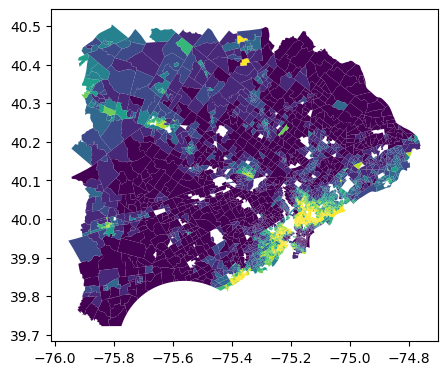

In [158]:
# basic plot showing ADI
fig, ax = plt.subplots(figsize=(5,5))
df.plot(ax=ax, cmap = 'viridis', column = 'ADI_STATERNK')

In [159]:
geo_jsn = json.loads(df.to_json())

In [160]:
type(geo_jsn)

dict

In [22]:
# geo_jsn['features'][0]['geometry']['coordinates'][0]

In [23]:
# geo_jsn

In [25]:
# this map works
# df.explore(column='ADI_STATERNK',tiles='CartoDB positron',cmap='flare')

# Yelp Data

In [161]:
path =  os.getcwd() + "/yelp_dataset/"

### Business Dataset

In [110]:
df_bus = pd.read_json(path+'yelp_academic_dataset_business.json', lines=True)

In [111]:
df_bus.shape

(150346, 14)

In [112]:
df_bus.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [64]:
df_bus.groupby("state").size().sort_values(ascending=False)

state
PA     34039
FL     26330
TN     12056
IN     11247
MO     10913
LA      9924
AZ      9912
NJ      8536
NV      7715
AB      5573
CA      5203
ID      4467
DE      2265
IL      2145
TX         4
CO         3
HI         2
MA         2
WA         2
NC         1
SD         1
MT         1
MI         1
UT         1
VI         1
VT         1
XMS        1
dtype: int64

In [113]:
# dropping unused columns
desired_attributes=['business_id','city','state','name','latitude','longitude','stars','review_count','categories']

In [114]:
df_bus_PA = df_bus[df_bus['state']=='PA'][desired_attributes].dropna()

In [115]:
# adding text column for hover info
df_bus_PA['text'] = df_bus_PA.name + "<br>" + df_bus_PA.stars.astype(str) + " stars<br>" + df_bus_PA.review_count.astype(str) + " reviews"

In [116]:
df_bus_PA.head(3)

,business_id,city,state,name,latitude,longitude,stars,review_count,categories,text
3,MTSW4McQd7CbVtyjqoe9mw,Philadelphia,PA,St Honore Pastries,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",St Honore Pastries<br>4.0 stars<br>80 reviews
4,mWMc6_wTdE0EUBKIGXDVfA,Green Lane,PA,Perkiomen Valley Brewery,40.338183,-75.471659,4.5,13,"Brewpubs, Breweries, Food",Perkiomen Valley Brewery<br>4.5 stars<br>13 re...
15,MUTTqe8uqyMdBl186RmNeA,Philadelphia,PA,Tuna Bar,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",Tuna Bar<br>4.0 stars<br>245 reviews


In [69]:
df_bus_PA.describe() #latitude > 39.75

,latitude,longitude,stars,review_count
count,34013.000000,34013.000000,34013.000000,34013.000000
mean,40.047374,-75.229933,3.574442,45.294681
std,0.120718,0.183097,0.965650,116.558986
min,39.696345,-75.799287,1.000000,5.000000
25%,39.951184,-75.321035,3.000000,8.000000
50%,40.021589,-75.176942,3.500000,15.000000
75%,40.130542,-75.139307,4.500000,39.000000
max,40.449748,-74.766048,5.000000,5721.000000


In [70]:
df_bus_PA.shape

(34013, 10)

In [71]:
df_bus_PA.groupby('city').size().sort_values(ascending=False).head(10)

city
Philadelphia       14558
West Chester         838
King of Prussia      559
Doylestown           538
Bensalem             453
Norristown           447
Exton                419
Lansdale             378
Ardmore              376
Wayne                375
dtype: int64

<AxesSubplot:xlabel='stars', ylabel='Count'>

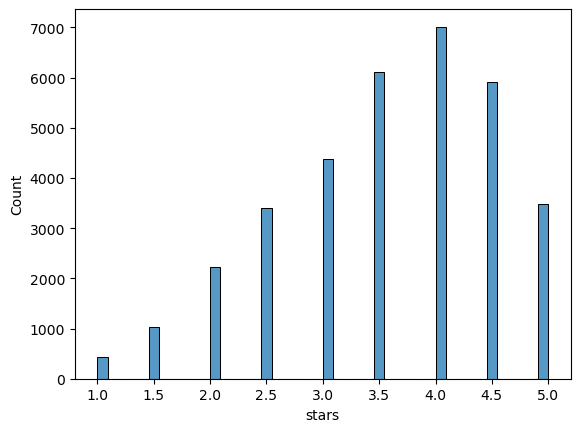

In [35]:
sns.histplot(data=df_bus_PA, x="stars") # left skewed

<AxesSubplot:xlabel='review_count', ylabel='Count'>

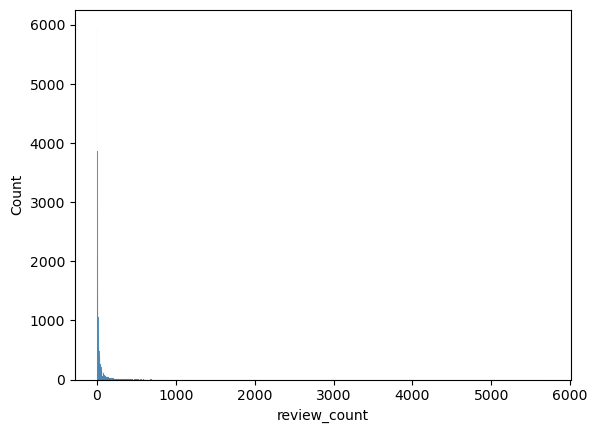

In [151]:
sns.histplot(data=df_bus_PA, x="review_count") # power law review count distr

In [93]:
# df_bus_PA['log_review_count']= np.log(df_bus_PA['review_count'])

<AxesSubplot:xlabel='log_review_count', ylabel='Count'>

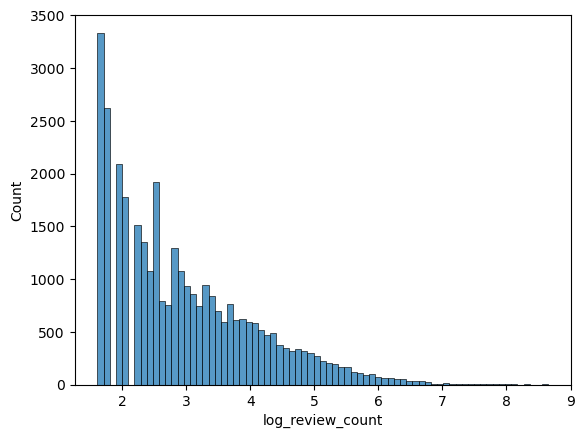

In [94]:
sns.histplot(data=df_bus_PA, x="log_review_count")

##### Business Categories

In [ ]:
categories_lst = []
for i in df_bus_PA[['categories']].itertuples():
    categories_lst+=i.categories.split(", ")

In [ ]:
df_PA_cat = pd.DataFrame(categories_lst, columns=['category'])

In [ ]:
df_PA_cat.category.nunique()

In [ ]:
df_PA_cat.groupby('category').size().sort_values(ascending=False).head(10)

# Mapbox plots

In [117]:
token = "pk.eyYOURTOKEN"

#### Data subset for quick plotting

In [187]:
df_bus_PA_small =df_bus_PA[1:250]
df_small =df[1:250]
geo_jsn_small = json.loads(df_small.to_json())

#### No Token Plotly.Express Choropleth

In [178]:
fig = px.choropleth_mapbox(df, 
                           geojson=geo_jsn,
                           locations='id', color='ADI_STATERNK',
                           color_continuous_scale="Viridis",
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 40, "lon": -75},
                           opacity=0.5,
                           labels={'ADI_STATERNK':'state ADI rank (deciles)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### No Token Choroplethmapbox from  Plotly.graphic_objects

In [180]:
fig = go.Figure(go.Choroplethmapbox(geojson=geo_jsn, locations=df.id, z=df.ADI_STATERNK,
                                    colorscale="Viridis",
                                    marker_opacity=0.5, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=7.5, mapbox_center = {"lat": 40, "lon": -75})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Mapbox Choropleth with ADI CBGs (mapbox token needed)

In [183]:
fig = go.Figure(go.Choroplethmapbox(geojson=geo_jsn, locations=df.id, z=df.ADI_NATRANK,
                                    colorscale="Viridis", 
                                    marker_opacity=0.5, marker_line_width=0))
fig.update_layout(mapbox_style="light",mapbox_accesstoken=token,
                  mapbox_zoom=7, mapbox_center = {"lat": 40, "lon": -75})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Scattermapbox (token needed)

In [185]:
fig = go.Figure(go.Scattermapbox(
        lat=df_bus_PA.latitude,
        lon=df_bus_PA.longitude,
        mode='markers',
        text= df_bus_PA.text,
        marker=go.scattermapbox.Marker(
#             sizemin=3,
#             size=df_bus_PA.log_review_count, 
            size=3,
            color=df_bus_PA.stars, 
            showscale=True,
            colorscale='Bluered',
            colorbar=dict(title="stars")),))

fig.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=token,
        bearing=0,
        center=dict(
            lat=39.9986,
            lon=-75.127
        ),
        pitch=0,
        zoom=9
    ),
)


#### Choroplethmapbox (token needed)

In [190]:
# ADI block groups
fig=go.Figure(go.Choroplethmapbox(name="National ADI Percentile",
                                  geojson=geo_jsn_small, 
                                  locations=df_small.id,  
                                  z=df_small.ADI_NATRANK,
                                  colorscale="Bluered", #"Aggrnyl",
                                  marker=dict(opacity=.6,line_width=.5, ),
                                  colorbar=dict(title="National ADI Percentile",
                                                outlinewidth=0, 
                                                showticklabels=True,
                                                tickvals=[(i+1)*10 for i in range(10)],
                                                orientation='h',
                                                tickangle=45,
                                                y=-.25,
                                                ticktext=["1-10<br>least<br>disadvantaged", "11-20", "21-30","31-40",
                                                          "41-50","51-60","61-70","71-80","81-90","91-100<br>most<br>disadvantaged"],),
                                  hoverinfo='z', ))

fig.update_layout(title='Yelp Reviews for Penslyvannia Businesses',
                  mapbox_style="light",
                  height=800,
                  mapbox_accesstoken=token,
                  mapbox_zoom=6, 
                  mapbox_center = {"lat": 40.9, "lon": -75},
                 hovermode='closest',
                 )

fig.show()

#### Final Interactive Plot

In [176]:
fig = go.Figure()


# ADI block groups
fig.add_trace(
# trace_state=    
    go.Choroplethmapbox(name="State ADI Decile",
                                  geojson=geo_jsn, 
                                  locations=df.id,  
                                  z=df.ADI_STATERNK,
                                  colorscale="Bluered", #['#0000ff','#ff0000'],
                                  marker=dict(opacity=.65,line_width=.5, ),
                                  colorbar=dict(title="State ADI Decile",
                                                outlinewidth=0, 
                                                showticklabels=True,
                                                tickvals=[i+1 for i in range(10)],
                                                orientation='h',
                                                y=-.55,
                                                ticktext=["1<br>least<br>disadvantaged", "2", "3","4",
                                                          "5","6","7","8","9","10<br>most<br>disadvantaged"],),
                                  hoverinfo='z', )
)
fig.update_traces(visible=False)

fig.add_trace(
# trace_nat=  
go.Choroplethmapbox(name="National ADI Percentile",
                                  geojson=geo_jsn,
                                  locations=df.id,  
                                  z=df.ADI_NATRANK,
                                  colorscale="Bluered",
                                  marker=dict(opacity=.65,line_width=.5, ),
                                  colorbar=dict(title="National ADI Percentile",
                                                outlinewidth=0, 
                                                showticklabels=True,
                                                tickvals=[(i*10+5) for i in range(10)],
                                                orientation='h',
#                                                 tickangle=45,
                                                y=-.55,
                                                ticktext=["1-10<br>least<br>disadvantaged", "11-20", "21-30","31-40",
                                                          "41-50","51-60","61-70","71-80","81-90","91-100<br>most<br>disadvantaged"],),
                                  hoverinfo='z', )
)



# Scatter plot
fig.add_trace(
# trace_scatter =    
    go.Scattermapbox(name="Yelp",
        lat=df_bus_PA.latitude,
        lon=df_bus_PA.longitude,
        mode='markers',
        text= df_bus_PA.text,
        marker=go.scattermapbox.Marker(
#             size=df_bus_PA.log_review_count, 
            size=3,
            color=df_bus_PA.stars, 
            showscale=True,
            colorscale= ["orange","green"],
            colorbar=dict(title="Stars",ticks="outside",)),)
    )


caption = """
Mean star rating of businesses in the greater Philadelphia area with Area Deprivation Index (ADI) data for Census Block Groups at the state and national levels.<br>
This figure combines open source (1) business and review data from Yelp, (2) ADI data from the Neighborhood Atlas, and (3) geographic Census Block Group datafrom the National Historical Geographic 
<br> Information System (NHGIS).
<br><br>
[1] https://www.yelp.com/dataset \t [2] Kind AJH, Buckingham W. Making Neighborhood Disadvantage Metrics Accessible: The Neighborhood Atlas. New England Journal of Medicine, 2018. 378: 2456-2458. 
<br> DOI: 10.1056/NEJMp1802313. PMCID: PMC6051533. AND University of Wisconsin School of Medicine Public Health. 2015 Area Deprivation Index v2.0. Downloaded from https://www.neighborhoodatlas.medicine.wisc.edu/ 
<br> May 23, 2019. \t [3] Steven Manson, Jonathan Schroeder, David Van Riper, Tracy Kugler, and Steven Ruggles. IPUMS National Historical Geographic Information System: Version 17.0 [dataset].
<br> Minneapolis, MN: IPUMS. 2022. http://doi.org/10.18128/D050.V17.0 
"""

fig.update_layout(title='Yelp Star Rating for Philadelphia Businesses with Measures of Neighborhood Disadvantage',
                  mapbox_style="light",
                  height=900,
                  mapbox_accesstoken=token,
                  mapbox_zoom=8, 
                  mapbox_center = {"lat": 40.1, "lon": -75.198},
                 hovermode='closest',
#                   xaxis_title='x',
                  xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Fruits<br><sup>Fruit sales in the month of January</sup>"
            )
        ),
    annotations=[
        dict(text="ADI Level", x=.83, y=1.11,# yref="paper",
                             align="left", showarrow=False),
        
        dict(text=caption,align="left", y=-.3,showarrow=False,),#,y=1
    ])


fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=2,
        showactive=True,
        x = 1,
        xanchor = 'right',
        y = 1.12,
        yanchor = 'top',
        buttons=list(
            [dict(label = 'Hidden',
                  method = 'update',
                  args = [{'visible': [ False, False,True]}]),
             
             dict(label = 'State Deciles',
                  method = 'update',
                  args = [{'visible': [ True, False,True]},]),
             
             dict(label = 'National Percentiles',
                  method = 'update',
                  args = [{'visible': [ False, True,True]}]),
            ], ))])

fig.show(renderer="browser")

In [167]:
# fig.write_html("interactive_mini_map.html")

# Examples

In [48]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

counties["features"][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]},
 'id': '01001'}